# DA - Project 3

Team members:

* Piotr Balewski - 156037
* Vasyl Korzavatykh - 158669

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from typing import Tuple
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import seaborn as sns
import xgboost as xgb
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from xgboost import plot_tree as xg_plot_tree
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.tree import DecisionTreeClassifier, plot_tree
from utils import *
from ANN_UTADIS.uta import Uta
from ANN_UTADIS.norm_layer import NormLayer

PATH = "uta.pt2"

## Utility functions

Some function below are taken from the notebooks provided during the labs (those with nice comments:)). Others were written by ourselves to complete the project.

In [ ]:
def partial_dependency(
    booster: xgb.Booster, X: np.ndarray, y: pd.Series, f_id: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate the partial dependency of a feature on the predicted outcome.
    
    Args:
        booster (xgb.Booster): The trained XGBoost model.
        X (np.ndarray): The input feature matrix.
        y (pd.Series): The target variable.
        f_id (int): The index of the feature for which the partial dependency is calculated.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing two numpy arrays:
        - grid: The values of the feature used for calculation.
        - y_pred: The predicted outcomes corresponding to each value in the grid.
    """
    grid = np.linspace(0, 1, 50)
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X.copy()
        X_temp[:, f_id] = val
        data = xgb.DMatrix(pd.DataFrame(X_temp))
        y_pred[i] = np.average(booster.predict(data))
    return grid, y_pred


def load_data(path: str, target_map: dict, criteria_nr: int, test_size=0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        criteria_nr (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :criteria_nr].values
    data_target = data[criteria_nr].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=test_size, random_state=17
    )

    return (X_train, X_test, y_train, y_test)


def report_model_performance(model, X, y, d="train"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, y_pred)
    print(f"Accuracy on {d} set:\t{accuracy:.2%}")
    print(f"AUC on {d} set: \t{auc:.2%}")
    print(f"F1 on {d} set: \t{f1:.2%}\n")
    return y_prob, accuracy, auc, f1


def report_UTADIS_performance(model, X, y, d="train"):
    all_outputs = []
    dataloader = CreateDataLoader(X, y)
    with torch.no_grad():
        for _, data in enumerate(dataloader, 0):
            inputs, _ = data
            outputs = model(inputs)
            all_outputs.append(outputs)

    all_outputs = torch.cat(all_outputs, dim=0)
    preds = (all_outputs > 0).int().squeeze()
    accuracy = accuracy_score(y, preds)
    auc = roc_auc_score(y, all_outputs)
    f1 = f1_score(y, preds)
    print(f"Accuracy on {d} set:\t{accuracy:.2%}")
    print(f"AUC on {d} set: \t{auc:.2%}")
    print(f"F1 on {d} set: \t{f1:.2%}\n")
    return accuracy, f1


def find_smallest_change(model, alt, column_names, typeS, prec=0.01):
    def get_pred(alt):
        if typeS == "usual":
            return model.predict([alt])[0]
        return model.predict(torch.Tensor(alt))[0]
    
    pred = get_pred(alt)
    alt = np.array(alt)
    necessary_changes = {i: float('inf') for i in range(len(alt))}

    for i in range(len(alt)):  # for each criterion
        d = prec
        while True:
            new_alt = alt.copy()
            new_alt[i] += d
            if new_alt[i] > 1:
                break
            if get_pred(new_alt) != pred:
                necessary_changes[i] = d
                break
            d += prec
        
        d = prec
        while True:
            new_alt = alt.copy()
            new_alt[i] -= d
            if new_alt[i] < 0:
                break
            if get_pred(new_alt) != pred:
                if (d < necessary_changes[i]):
                    necessary_changes[i] = -d
                break
            d += prec
    
    min_change, min_criterion = float('inf'), float('inf')
    for key, value in necessary_changes.items():
        if abs(min_change) > abs(value):
            min_change, min_criterion = value, key

    if min_change < 1:
        print(f"Minimal change: Criterion {column_names[min_criterion]} (Feature {min_criterion}) by {min_change}")
        print(f"Necessary changes on each criterion: {necessary_changes}")
    else:
        print("Change on no single criterion is enough to change the classification")

    return min_change, min_criterion


def plot_change_usual(model, alt, change, criterion):
    explainer = shap.Explainer(model)
    shap_values = explainer([alt])

    print("Before change:")
    _ = shap.plots.waterfall(shap_values[0])

    new_alt = alt.copy()
    new_alt[criterion] += change
    shap_values = explainer([new_alt])
    
    print("After change:")
    _ = shap.plots.waterfall(shap_values[0])


def get_minimal_change_analysis(model, column_names, alt, typeS="usual"):
    for i in range(len(alt)):
        print(f"Alternative {i + 1}:")
        alt_i = np.array(alt.iloc[i][:6]).astype(np.float64)
        min_change, min_criterion = find_smallest_change(model, alt_i, column_names, typeS)
        if min_change < 1:  # check if not float('inf')
            print()
            try:
                if typeS == "usual":
                    plot_change_usual(model, alt_i, min_change, min_criterion)
            except:
                # print("Couldn't print the SHAP summary:(")
                ...
        print()

## Dataset

We chose the dataset provided in the list of advisable datasets, namely, the one concerning **Computer Hardware**. We pulled the names of the columns from https://archive.ics.uci.edu/dataset/29/computer+hardware, and the data itself was downloaded from eKursy.

The cleaned dataset has 6 criteria, one decision variable, and 209 instances.

**Criteria**: 
1. MYCT: machine cycle time in nanoseconds
2. MMIN: minimum main memory in kilobytes
3. MMAX: maximum main memory in kilobytes
4. CACH: cache memory in kilobytes
5. CHMIN: minimum channels in units
6. CHMAX: maximum channels in units

**Note**: Original dataset had everything in integers, however, pulled dataset was already preprocessed with Min-Max Scaler.

All criteria except for cycle time are expected to be of a gain type and MYCT is the only criterion of the cost type.

The decision variable is the performance of a CPU on a scale from 0 to 3. For the purpose of this project we will binarize the decision class according to the following rule:

* [0, 1] -> 0 ("low")
* [2, 3] -> 1 ("high")

In [3]:
column_names = ["MYCT", "MMIN", "MMAX", "CACH",	"CHMIN", "CHMAX", "Class"]

data = data = pd.read_csv("../cpu.csv", header=None, names=column_names)
data['Class'] = data['Class'].apply(lambda x: 0 if x in [0, 1] else 1)  # Binarization

data

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Class
0,0.072825,0.006012,0.092843,1.000,0.307692,0.727273,1
1,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,1
2,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,1
3,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,1
4,0.008092,0.248497,0.249249,0.125,0.153846,0.090909,1
...,...,...,...,...,...,...,...
204,0.072151,0.029309,0.124124,0.000,0.019231,0.045455,0
205,0.054619,0.029309,0.124124,0.125,0.038462,0.045455,1
206,0.072825,0.060621,0.124124,0.000,0.038462,0.079545,0
207,0.312205,0.014028,0.124124,0.125,0.000000,0.000000,1


In [4]:
dataset_path = "../cpu.csv"
target_map = {0: 0, 1: 0, 2: 1, 3: 1}
criteria_nr = 6
test_size = 0.2
SEED = 17

In [5]:
X_train, X_test, y_train, y_test = load_data(
    dataset_path,
    target_map,
    criteria_nr,
    test_size
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (152, 6) (152,)
Test shapes: (38, 6) (38,)


## 1. XGBoost model

In [6]:
# Initialize the XGBoost parameters
params = {
    "max_depth": criteria_nr * 2,   # Maximum depth of a tree
    "eta": 0.1,                     # Learning rate
    "nthread": 5,                   # Number of parallel threads
    "seed": SEED,                   # Random seed
    "eval_metric": "logloss",       # Evaluation metric
    "monotone_constraints": "("
    + ",".join(["0"] * criteria_nr) # Monotonic constraints for each criterion (1 = increasing, -1 = decreasing, 0 = no constraint)
    + ")",                          # Set to 0 (no constraint)
    "n_estimators": 30,             # Number of boosting rounds, or trees
}

In [7]:
model = xgb.XGBClassifier(**params)
_ = model.fit(X_train, y_train)

In [8]:
_ = report_model_performance(model, X_train, y_train, "train")
_ = report_model_performance(model, X_test, y_test, "test")

Accuracy on train set:	100.00%
AUC on train set: 	100.00%
F1 on train set: 	100.00%

Accuracy on test set:	94.74%
AUC on test set: 	99.17%
F1 on test set: 	94.12%



The first out of `n_estimators` trees looks as follows:

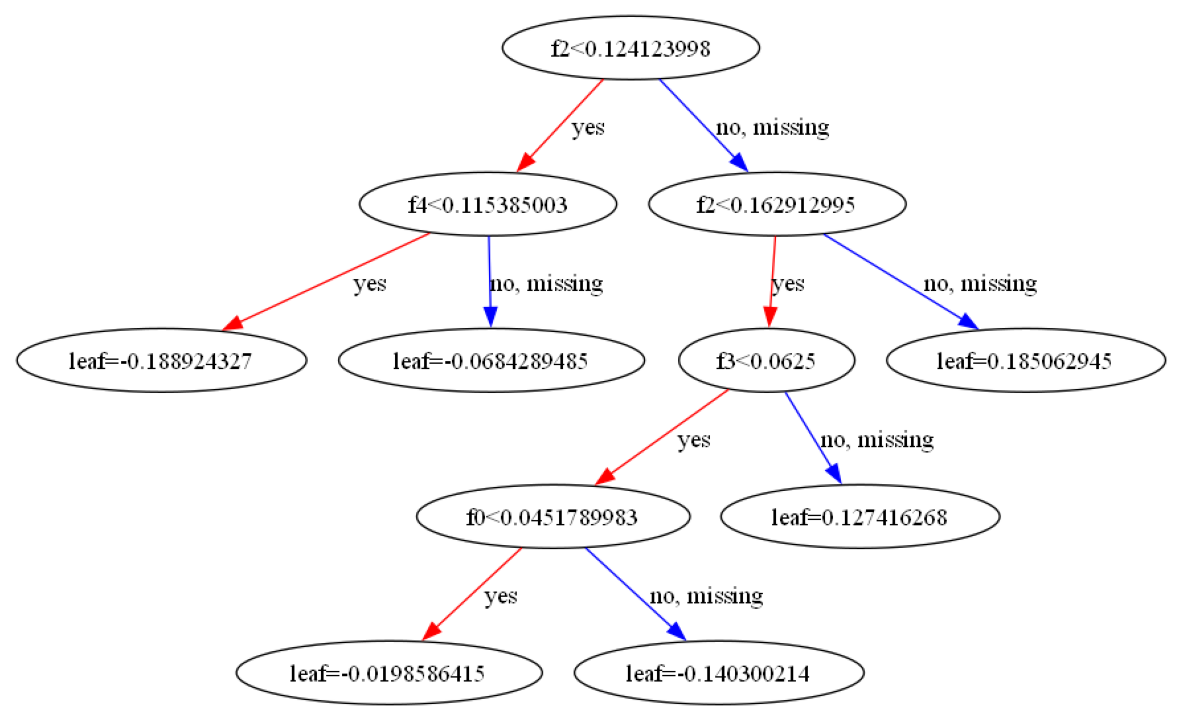

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = xg_plot_tree(model, ax=ax, tree_idx=0)

In [10]:
booster = model.get_booster()
print("How many times the criteria appeared in the trees:")
for i, (_, value) in enumerate(booster.get_fscore().items()):
    print(f"{column_names[i]}: {value}")

How many times the criteria appeared in the trees:
MYCT: 25.0
MMIN: 28.0
MMAX: 42.0
CACH: 33.0
CHMIN: 14.0
CHMAX: 11.0


In [11]:
print("Weighted importance:")
for i, (_, value) in enumerate(booster.get_score(importance_type="gain").items()):
    print(f"{column_names[i]}: {value:.4}")

Weighted importance:
MYCT: 0.7315
MMIN: 1.864
MMAX: 17.26
CACH: 4.903
CHMIN: 0.324
CHMAX: 0.8802


### Feature importance using permutation importance

We identified that CHMIN is the least influencing criterion while MMAX is the most important one. It is in line with weighted importances presented above.

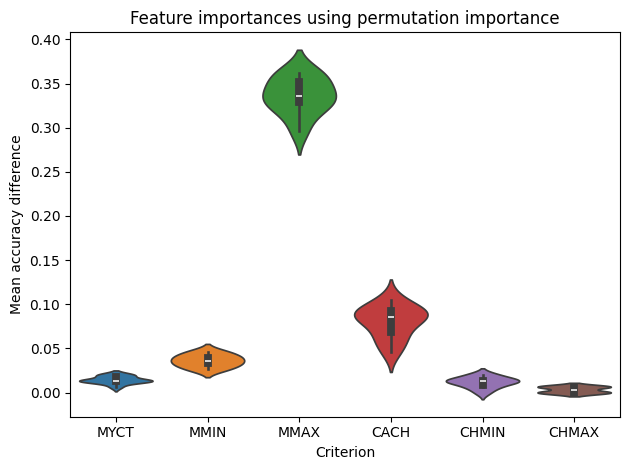

In [12]:
result = permutation_importance(
    model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=SEED
)

fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(result.importances.T, columns=column_names[:-1]), ax=ax)
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
ax.set_xlabel("Criterion")
fig.tight_layout()

### Partial dependency plots for each criterion

Below one can see Partial Dependency plots for each criterion. 

* The first thing we notice is that all criteria but the first one (MYCT) are of a gain type. Machine cycle time in nanoseconds is identified as a cost-type criterion which is in line with our prior expectations.
* Moreover, MMAX seems to be the most influencial criterion (when its standardized value is greater than 0.2, the CPU is classified as 'good' in around 90% of instances).

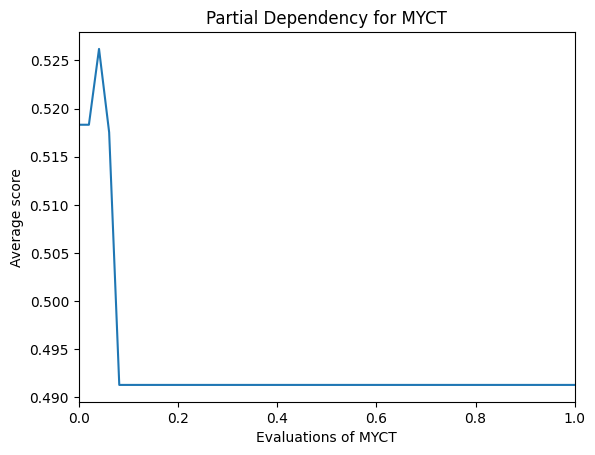

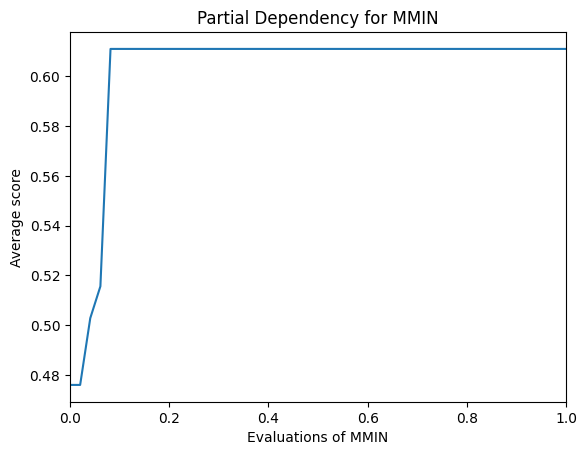

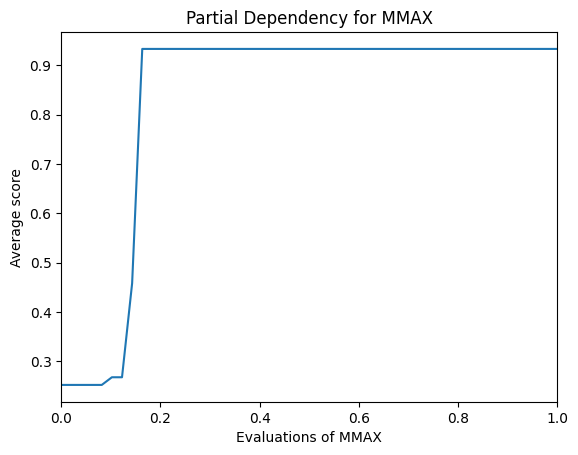

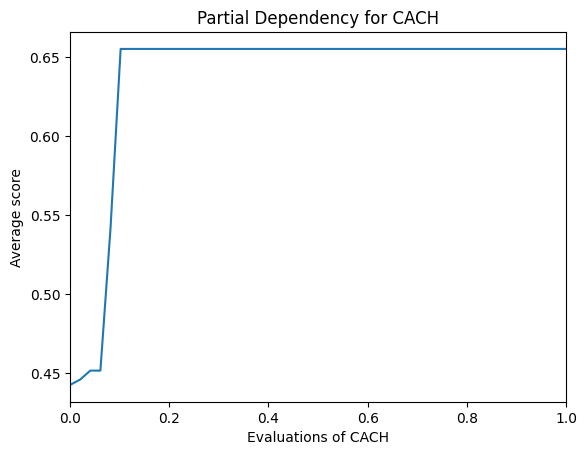

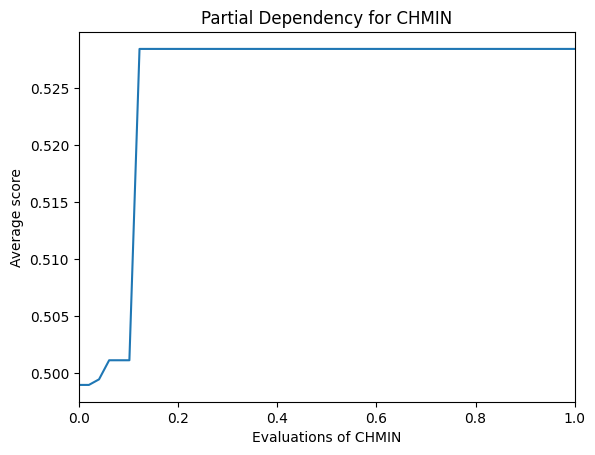

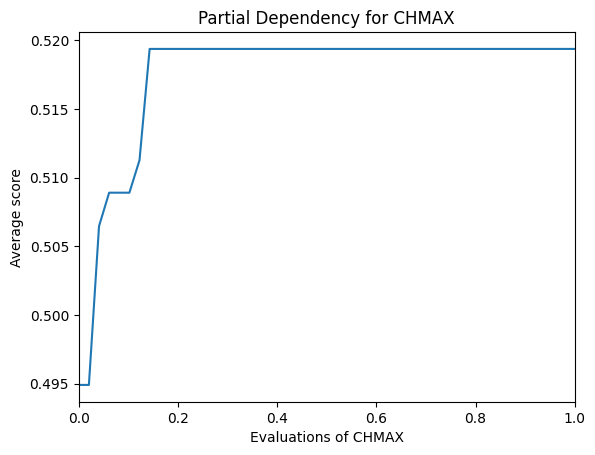

In [13]:
grid = np.linspace(0, 1, 50)

for c in range(criteria_nr):
    grid, y_pred = partial_dependency(booster, X_train, y_train, c)
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred)
    ax.set_xlim(0, 1)
    ax.set_title(f"Partial Dependency for {column_names[c]}")
    ax.set_xlabel(f"Evaluations of {column_names[c]}")
    ax.set_ylabel("Average score")

For the following partial dependency plots we will be using only the first 4 parameters (the first one is interesting because it is of the cost type and the three next parameters are the most influencial).

We can see that MMAX has the largest importance and it dominates (is visible on the last 2 plots) both other most importance criteria (MMIN and CACH).

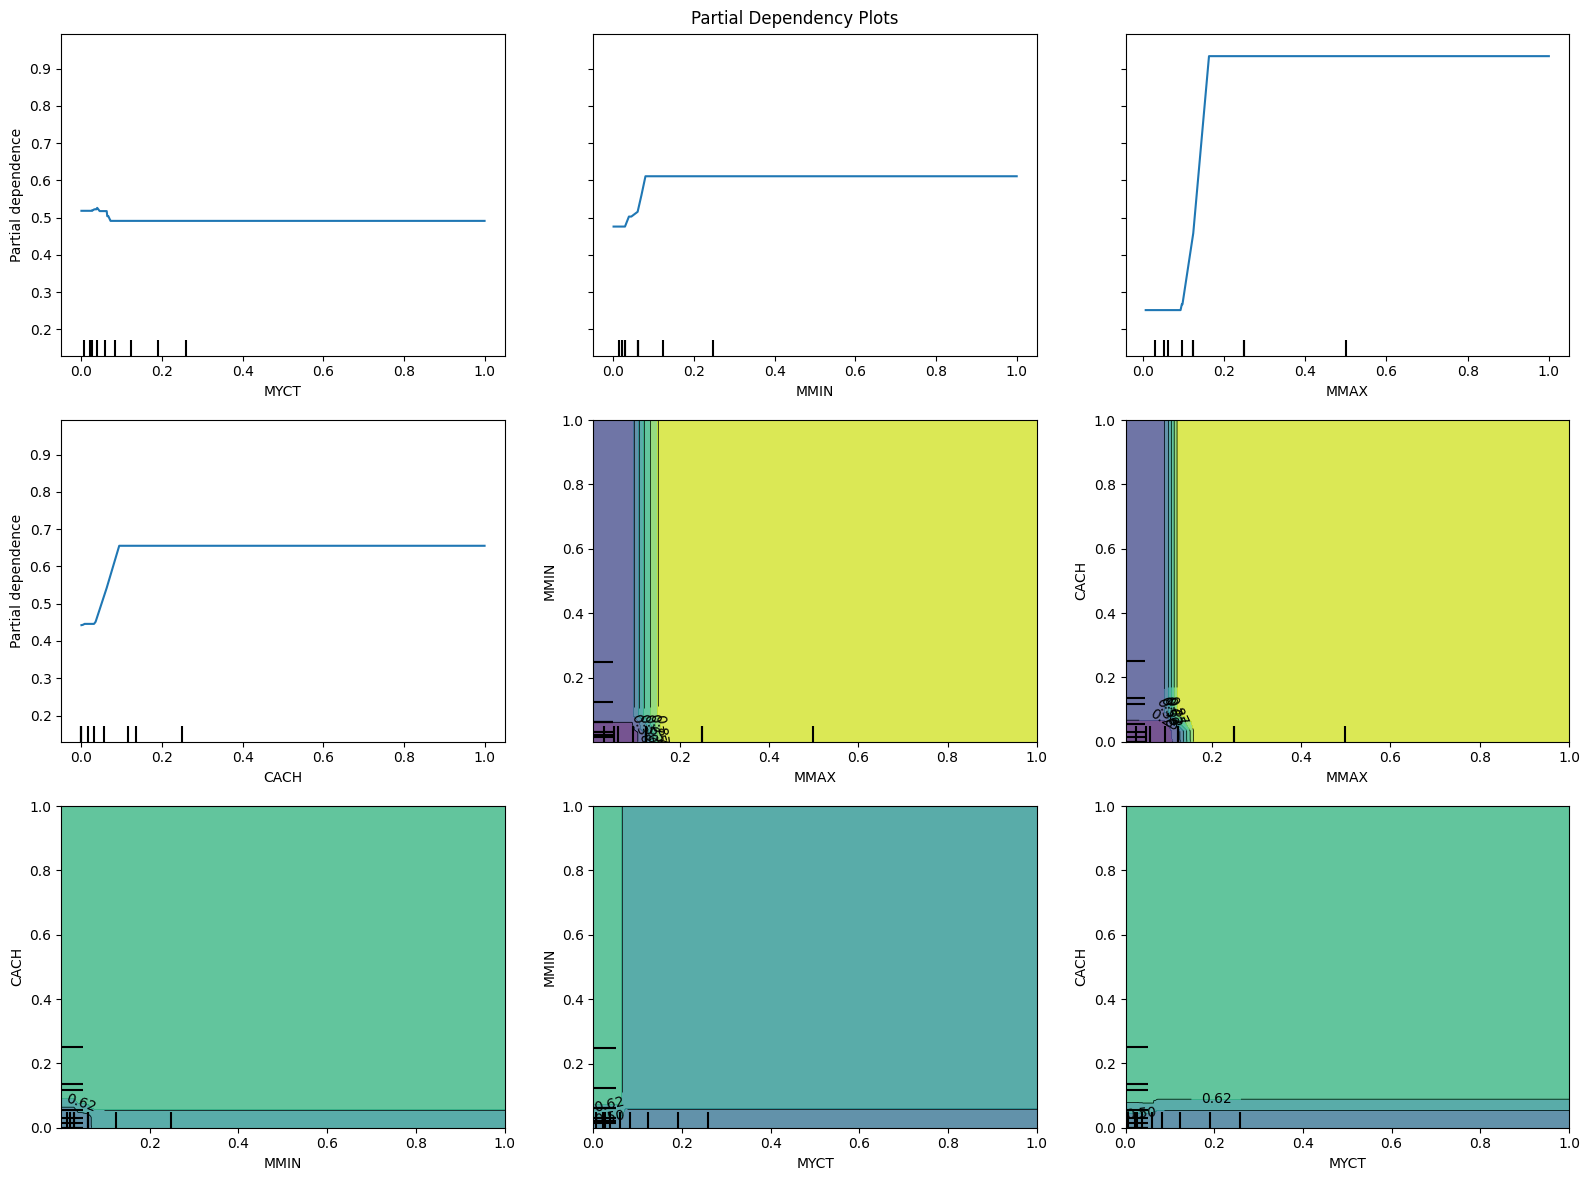

In [14]:
features = [
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    ("MMAX", "MMIN"),
    ("MMAX", "CACH"),
    ("MMIN", "CACH"),
    ("MYCT", "MMIN"),
    ("MYCT", "CACH")
]

fig, ax = plt.subplots(figsize=(16, 12))
PartialDependenceDisplay.from_estimator(
    model, 
    X_train, 
    features=features,
    feature_names=column_names[:-1],
    ax=ax
)

plt.suptitle("Partial Dependency Plots")
plt.tight_layout()
plt.show()

### Explanation of the decisions

For all the models we will be using the same alternatives (0, 10, 55) and the same set of functions. The first part of the section would be unique for each model though because to showing why a certain decision was made is different for each model. However, in the second section we will analyze the predictions using SHAP values.

Alternative 0 is on the brink between the class low and high. Alternatives 10 and 55 are leaning towards low and high classification correspondingly. You may uncomment the sample line and comment the second line to look at randomly sampled instances, however, they are not really interesting (they are very clearly belonging to a certain class and no change on a single criterion is actually making the difference for them).

In [15]:
# alt = data.sample(3, random_state=SEED)
alt_sample_idx = [0, 10, 55]
alt = data.iloc[alt_sample_idx]
alt

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Class
0,0.072825,0.006012,0.092843,1.0000,0.307692,0.727273,1
10,0.258260,0.029309,0.045921,0.0000,0.019231,0.011364,0
55,0.062711,0.029309,0.186687,0.0625,0.019231,0.011364,1


#### Why XGBoost classified alternatives this way?

In order to understand why XGBoost classified an instance in a certain way one should analyze all the trees and find the sum of predictions. In our case we used 30 trees so it will be infeasible to go through each of them. Nevertheless, we may look at the first tree and see if we can find any patterns.

**Alternative 0**:

f2 < 0.124123998 -> yes -> f4 < 0.115385003 -> no -> -0.0684289485 (slightly leans towards 0 class)

We can see that the first tree would classify the instance as 'low' performance CPU, however, with rather low certainty. In reallity all the trees combined would classify this CPU as 'high', however, as we mentioned earlier alternative 0 is on the brink of two classes (this is why we included it in the sample).

**Alternative 10**:

f2 < 0.124123998 -> yes -> f4 < 0.115385003 -> yes -> -0.188924327 (leans towards 0 class)

Alternative 10 is clearly leaning towards the 0 class ('low') and it is in line with general prediction.


**Alternative 55**:

f2 < 0.124123998 -> no -> f2 < 0.162912995 -> no -> 0.185062945 (leans towards 1 class)

Alternative 55 is clearly leaning towards the 1 class ('high') and it is in line with general prediction.

In [16]:
rules = model.get_booster().get_dump()
for i, tree in enumerate(rules[:1]):  # first tree
    print(f"Tree {i + 1}:")
    print(tree)

Tree 1:
0:[f2<0.124123998] yes=1,no=2,missing=2
	1:[f4<0.115385003] yes=3,no=4,missing=4
		3:leaf=-0.188924327
		4:leaf=-0.0684289485
	2:[f2<0.162912995] yes=5,no=6,missing=6
		5:[f3<0.0625] yes=7,no=8,missing=8
			7:[f0<0.0451789983] yes=9,no=10,missing=10
				9:leaf=-0.0198586415
				10:leaf=-0.140300214
			8:leaf=0.127416268
		6:leaf=0.185062945



#### Space sampling around the alternatives

Theoretically, the smallest change that should be done to an alternative for it to change the class should concern the most influencial criterion (MMAX was identified as the most important one for XGBoost). 

We can take each alternative and check what is actually the smallest change to a single criterion needed to achieve change of classification (we sample with a step of 0.01 on each criterion waiting for it to change the classification or hit the [0, 1] range boundaries).

Our experiments show that actually not always change on the most important criterion is decisive, because sometimes it is not enough:
* if all criteria make the instance of e.g. "low" class then change in single criterion might not be enough to outweight the rest
* if the most influencial criterion already has a value that makes the instance "more of a different class" then changing it further would have no effect (the preference threshold on the criterion was already passed)

Alternative 1:
Minimal change: Criterion MYCT (Feature 0) by -0.01
Necessary changes on each criterion: {0: -0.01, 1: inf, 2: 0.04, 3: inf, 4: inf, 5: inf}

Before change:


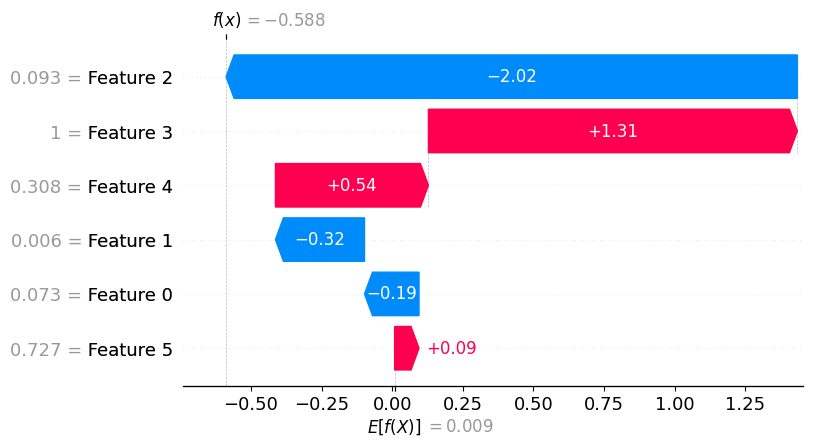

After change:


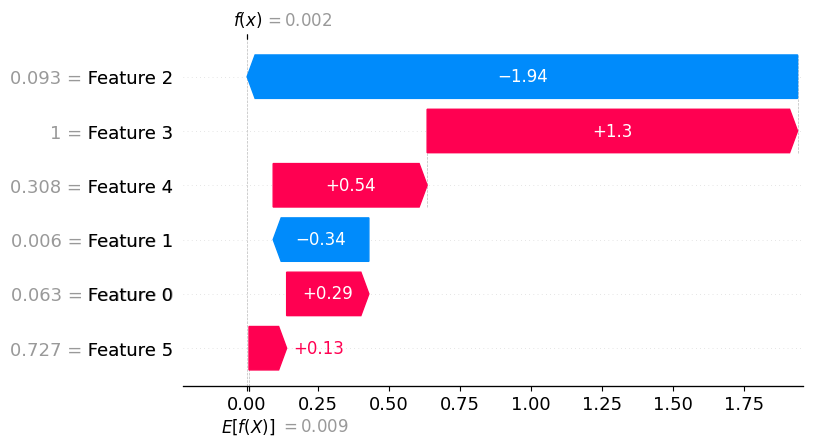


Alternative 2:
Minimal change: Criterion MMAX (Feature 2) by 0.11999999999999998
Necessary changes on each criterion: {0: inf, 1: inf, 2: 0.11999999999999998, 3: inf, 4: inf, 5: inf}

Before change:


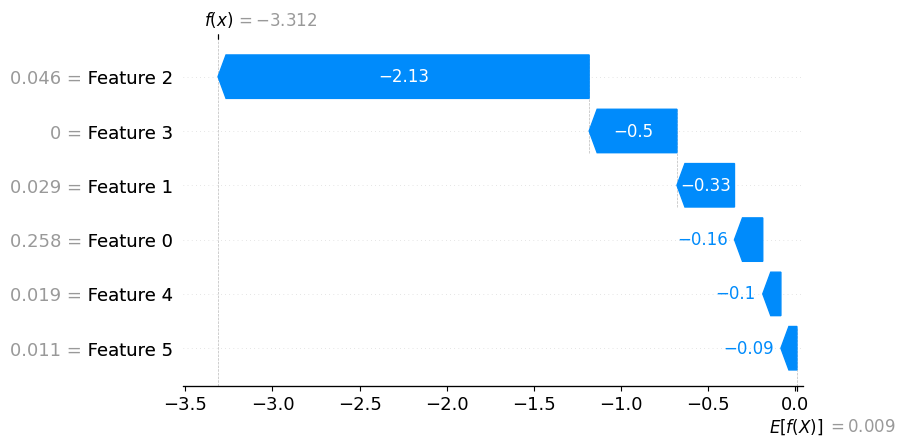

After change:


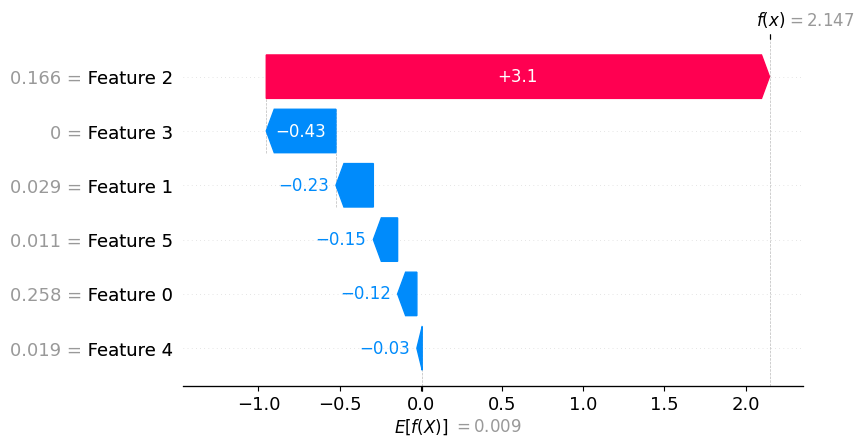


Alternative 3:
Minimal change: Criterion MMAX (Feature 2) by -0.03
Necessary changes on each criterion: {0: inf, 1: inf, 2: -0.03, 3: inf, 4: inf, 5: inf}

Before change:


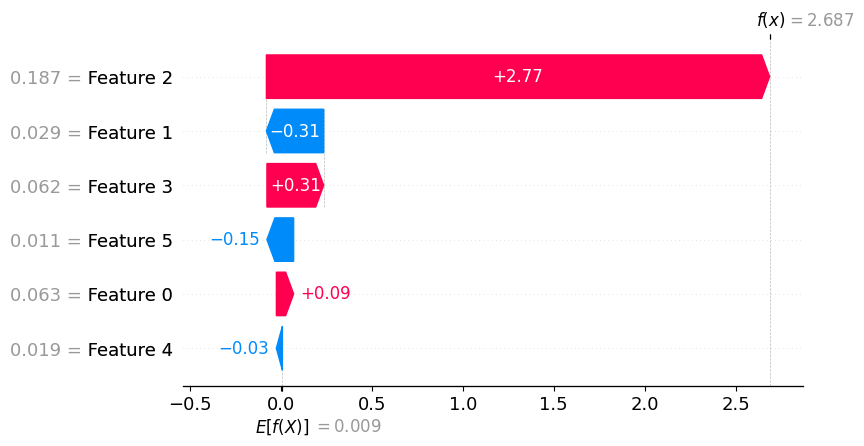

After change:


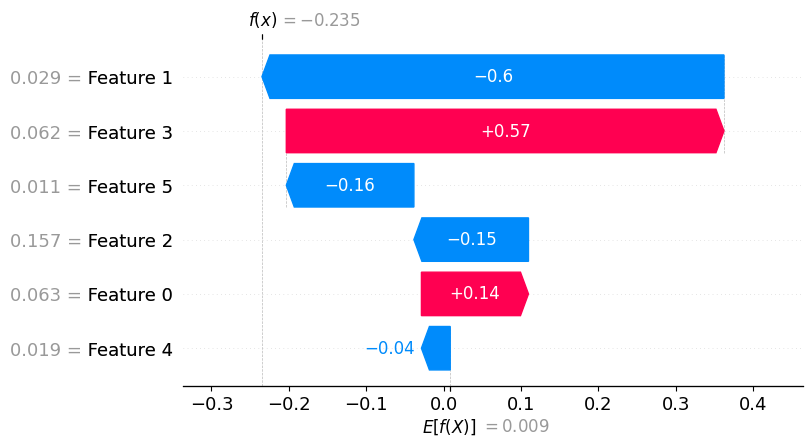

In [17]:
get_minimal_change_analysis(model, column_names, alt)

### XGBoost Summary

Quickly trained XGBoost obtained accuracy around 95% on the CPU dataset. The model was analyzed using Partial Dependency Plots, decisions were explained using the actual trees and sensetivity analysis was visualized using SHAP values.

**Based on the model analysis**:

* MMAX is the most influencial criterion (the most important for user)
* MMAX has a decisive influence and based on the violin plot CHMIN has the least (not exactly no, however almost no) influence on the decision
* All the criteria seem to be monotonic and as expected only the first criterion (MYCT) is of a cost type
* Preference thresholds are located in the range [0, 0.2] for all the criteria (can be seen from individual partial dependency plots)

**Based on the decisions**:

We calculated by hand what would be the classifications for the sample alternatives if there was only one tree involved. We've got consistent results (except for a partially inconsistent result for a boundary alternative) with the final classifications for those alternatives.

## 2. ANN-UTADIS model

In [18]:
data_input = data.iloc[:, :criteria_nr]
data_input['MYCT'] = data_input['MYCT'].apply(lambda x: 1 - x)  # reversing values for cost criterion
data_target = data['Class']

data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    data_input, data_target, test_size=test_size, random_state=SEED   # '_u' data dedicated for ANN_UTADIS model with reverse 1st column
)

train_dataloader = CreateDataLoader(X_train_u, y_train_u.to_numpy())
test_dataloader = CreateDataLoader(X_test_u, y_test_u.to_numpy())

In [19]:
uta = Uta(criteria_nr, 30)
torch.manual_seed(SEED)
model = NormLayer(uta, criteria_nr)
best_acc, best_auc, stats_train, stats_test = Train(
    model,
    train_dataloader,
    test_dataloader,
    PATH,
    epoch_nr=200,
    lr=0.01,
    slope_decrease=True
)

100%|██████████| 200/200 [00:01<00:00, 103.29it/s]


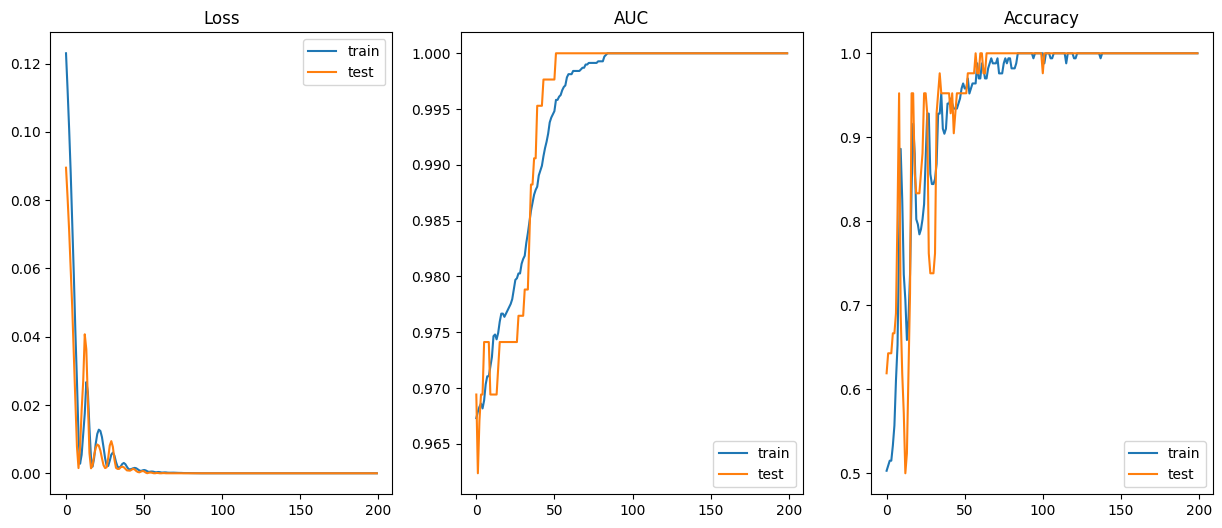

In [20]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

In [21]:
_ = report_UTADIS_performance(model, X_train_u, y_train_u.to_numpy(), "train")
_ = report_UTADIS_performance(model, X_test_u, y_test_u.to_numpy(), "test")

Accuracy on train set:	100.00%
AUC on train set: 	100.00%
F1 on train set: 	100.00%

Accuracy on test set:	100.00%
AUC on test set: 	100.00%
F1 on test set: 	100.00%



In [22]:
hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val, criteria_nr)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
# We take every third value becouse the rest are from the normalization layer: velues for 0 and 1
outs = outs[::3] - outs[::3][0]
# Normalize the outputs to get proper weights of the criteria
outs = outs / outs[-1].sum()

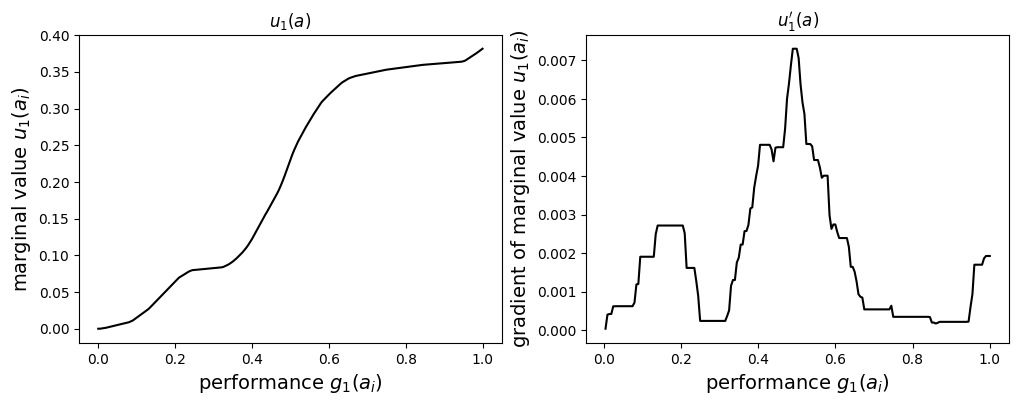

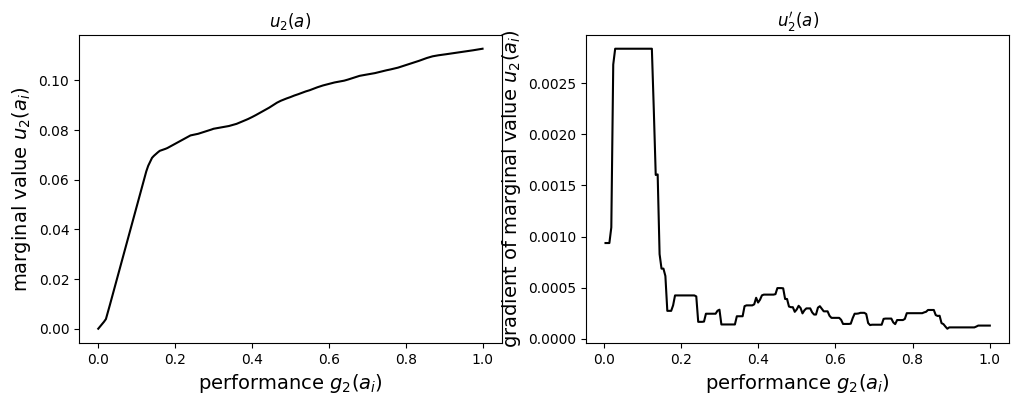

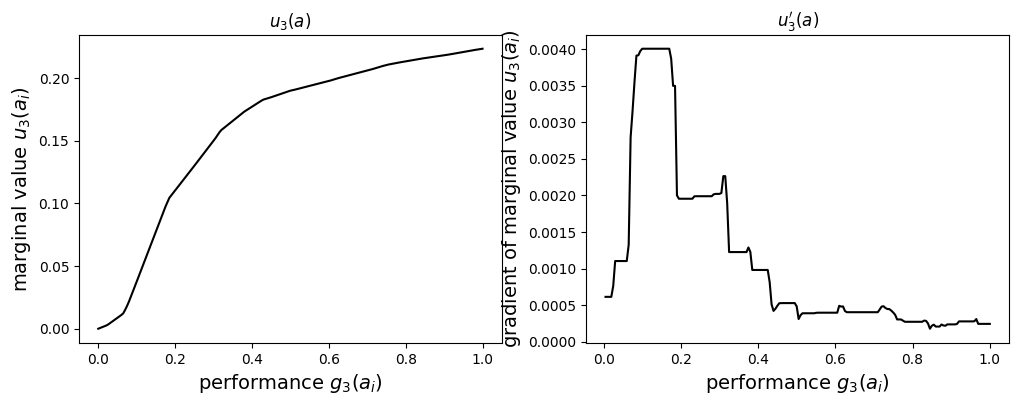

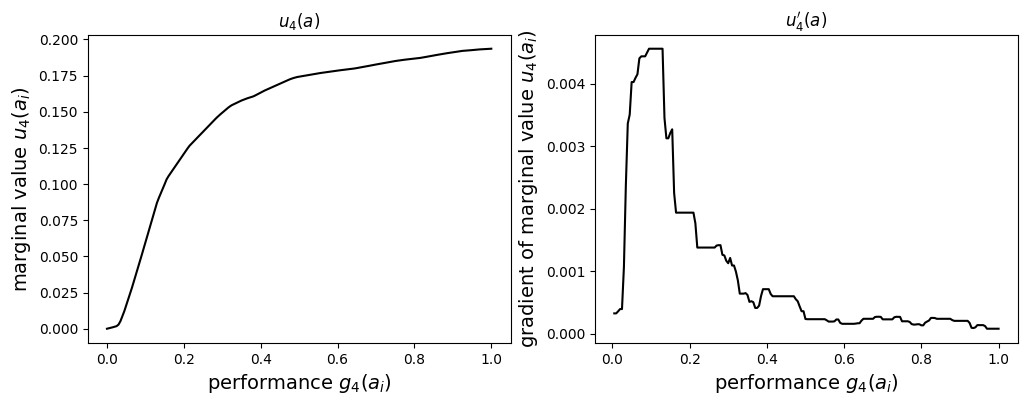

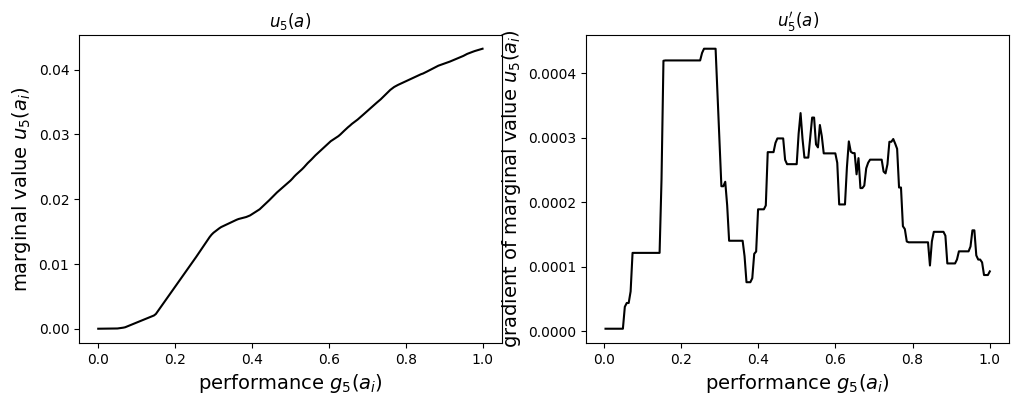

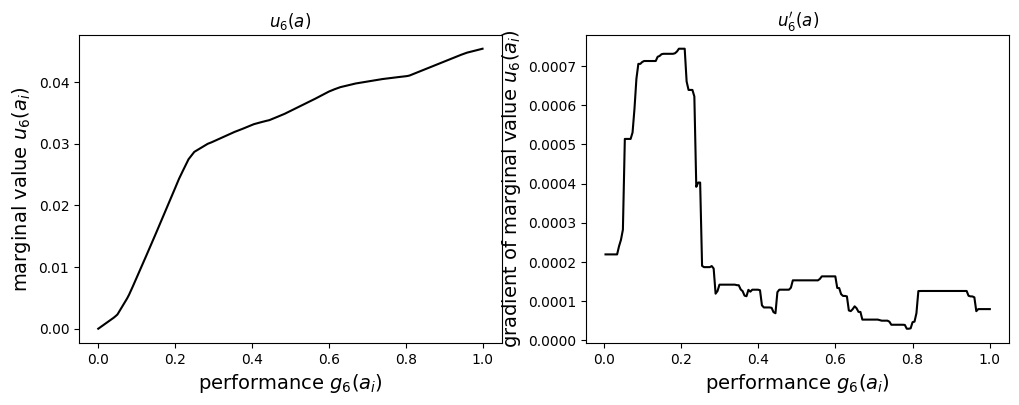

In [23]:
for i in range(criteria_nr):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

### Interpretation of the model

#### Feature importance

Based on the parametrs obtained we can see that most decisive feature for user is 1st one, as the amplitude of the marginal value function (criterion weight) equals 0.4, which is amlost half of total value - 1. Then criteria that are also important are 2nd, 3rd and 4th. Last two features are negligible.

#### Criteria nature

Nature of the criterion can not be readed from model analysis, as ANN-UTADIS consists of Monotonic Blocks which can only model non-decreasing utility functions. That's why 1 column values (gain criterion) need to be manually reversed before they are thrown into the model.

#### Indifference and preference thresholds

We see indifference thresholds (marginal value function derivative close to 0) for:

- 6th criterion at ~0.1

Soft prefference thresholds (marginal value function derivative close to 0 and non-increasing) for:

- 1st criterion at ~0.7

### Decisions explanation

In [24]:
x_alt = data_input[alt_sample_idx]
y_alt = data_target[alt_sample_idx]

In [25]:
alt_dataloader = CreateDataLoader(x_alt, y_alt)

with torch.no_grad():
    for _, data in enumerate(alt_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)

preds = (outputs > 0).int()

print(outputs)
print(preds)

tensor([ 0.1798, -0.0957,  0.0392])
tensor([1, 0, 1], dtype=torch.int32)


To understand how did ANN-UTADIS correctly classify those 3 alternatives is actually very simple. The only thing we need to look at is difference between utility value function for alternative and the threshold. If this difference is negative then predicted class is 0, otherwise 1.

Utility function is sum of marginal value functions for all criteria, which are calculated according to plots that were shown above. Lets look at those sums of value functions before and after normalization

Later lets substract threshold value, perform signum function and voilà - classification is done ;)

In [26]:
threshold_layer = model.thresholdLayer
for name, param in threshold_layer.named_parameters():
    print(f"{name.capitalize()}: {param.data[0]:.4f}\n")
    threshold = param.data

uta = model.method_instance

normalized_utilities = []

for i in range(3):
    print(f"{alt_sample_idx[i]}th alternative:")
    x_tensor = torch.tensor(x_alt[i], dtype=torch.float32).unsqueeze(0)  # Add batch dim
    with torch.no_grad():
        summed_utilities = uta.forward(x_tensor)
    print(f"Summed utilities before normalization: {summed_utilities[0]:.4f}")

    _ = model(x_tensor)  # Run full model to ensure all hooks are set
    normalized_sum = model.out
    print(f"After normalization: {normalized_sum[0]:.4f}")
    normalized_utilities.append(normalized_sum)

    output = normalized_sum - threshold
    pred = (output > 0).int()

    print(f"Value relative to threshold: {output[0]:.4f}")
    print(f"Predicted class: {pred[0]:.0f}")

    if i < 2: 
        print(f"\n-------------\n")

Threshold: 0.4653

0th alternative:
Summed utilities before normalization: 1.1880
After normalization: 0.6451
Value relative to threshold: 0.1798
Predicted class: 1

-------------

10th alternative:
Summed utilities before normalization: 0.6796
After normalization: 0.3695
Value relative to threshold: -0.0957
Predicted class: 0

-------------

55th alternative:
Summed utilities before normalization: 0.9286
After normalization: 0.5045
Value relative to threshold: 0.0392
Predicted class: 1


In [27]:
get_minimal_change_analysis(model, column_names, alt, typeS="custom")

Alternative 1:
Minimal change: Criterion MYCT (Feature 0) by 0.4000000000000002
Necessary changes on each criterion: {0: 0.4000000000000002, 1: inf, 2: 0.6200000000000003, 3: inf, 4: inf, 5: inf}


Alternative 2:
Change on no single criterion is enough to change the classification

Alternative 3:
Minimal change: Criterion MYCT (Feature 0) by 0.5500000000000003
Necessary changes on each criterion: {0: 0.5500000000000003, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf}




### ANN-UTADIS Summary

ANN-UTADIS model converges relatively quickly (after about 70 iterations) to 98% accuracy on both test and training dataset. We tested multiple learning rate values (0.1, 0.01, 0.001, 0.0001) and chose 0.01 as the best one. Initially the accuracy curve and loss function are quite 'sharp', as values are droping and rising in big amplitudes within a few iterations, however after 50-70 iterations the change becomes much more smoother.

To analyze model we plotted marginal value functions for each criterion, which essentially determine the whole model (apart from threshold value). Decisions were explained step by step by showing sum of utility functions before and after normalization and after substracting threshold value. The final step was to apply signum function.

**Based on the model analysis**:

* MYCT is the most influencial criterion (different than for XGBoost and NN models).
* CHMIN and CHMAX have the least influence on the decision
* All the criteria seem to be monotonic, but as stated above nature of the criterion can not be readed from model - it must be provided as input. 
* Analyzing derivatives of marginal value functions we can determine in which ranges change is critical for decision (for 2-6 criteria it is closer to the beginning of the scale, while for 1st one it's somewhere in the middle)

**Based on the decisions**:

We showed the whole computational process that is determining the final decision (classification).

## 3. Neural network model

As a neural network we use a simple Sequencial network with 3 linear layers (the 3rd one is summarizing one), ReLU activations, and sigmoid function in the end to get 0-1 classification.

In [8]:
class NN(nn.Module):
    def __init__(self, input_size, size=100, lr=0.01, batch_size=8, epochs=100, random_seed=None):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 1),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_seed = random_seed

    def forward(self, x):
        return self.model(x)

    def fit(self, X, y):
        if self.random_seed:
            torch.manual_seed(self.random_seed)

        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y).unsqueeze(1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.train()
            for inputs, labels in loader:
                outputs = self(inputs)
                loss = self.loss_fn(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

    def predict(self, X):
        if self.random_seed:
            torch.manual_seed(self.random_seed)

        self.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = self(X_tensor)
            return (outputs > 0.5).float()

For the neural network we use:

* `batch_size` = 8
* number of `epochs` = 100
* loss function - BCE loss
* optimizer - Adam with 0.01 learning rate

With such settings the network reaches quite high accuracy (~95% on the random seed = 17).

In [ ]:
model = NN(input_size=X_train.shape[1], random_seed=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
print("\nStats:")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')

Epoch 10, Loss: 0.0479
Epoch 20, Loss: 0.0019
Epoch 30, Loss: 0.3917
Epoch 40, Loss: 0.0002
Epoch 50, Loss: 0.0983
Epoch 60, Loss: 0.0022
Epoch 70, Loss: 0.0006
Epoch 80, Loss: 0.0484
Epoch 90, Loss: 0.0004
Epoch 100, Loss: 0.0094

Stats:
Accuracy: 0.9211
F1 Score: 0.9189


### Feature importance using permutation importance


Results for the custom NN are very similar to those obtained for XGBoost. MMAX is also identified as the most important criterion for the model (thus supposedly the most important for the DM). CACH is also consistently the second most important criterion, however, the least important criteria are MYCT and CHMIN.

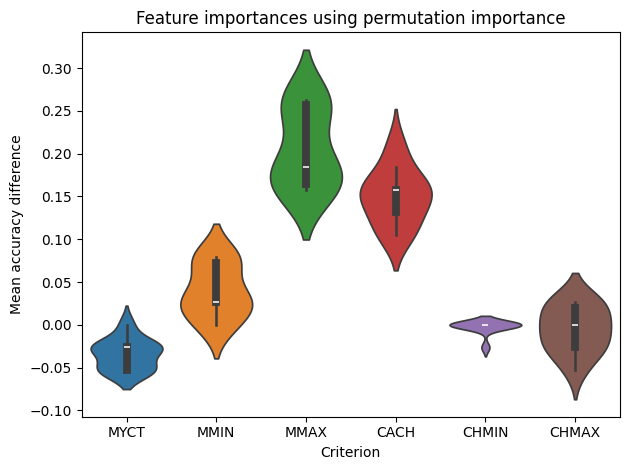

In [30]:
result = permutation_importance(
    model,
    X_test,
    y_test,
    scoring='accuracy',
    n_repeats=10,
    random_state=SEED
)

fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(result.importances.T, columns=column_names[:-1]), ax=ax)
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
ax.set_xlabel("Criterion")
fig.tight_layout()

#### Global Surrogate

In this section we use DecisionTreeClassifier to reproduce our NN with an interpretable model. This way we learn approximate rules behind the NN. We can't look inside directly because that's a 'black box', however, using permutation feature importance and global surrogate sheds light on how the NN might be explained.

By coincidence, both surrogate accuracy when compared to original NN and its accuracy when compared to the real targets are the same (around 90%), however, that's not more than a coincidence because all three variables (`y_test_pred`, `surrogate_pred`, and `y_test`) are actually different.

Surrogate accuracy compared to NN: 0.8947
Actual surrogate accuracy: 0.9211


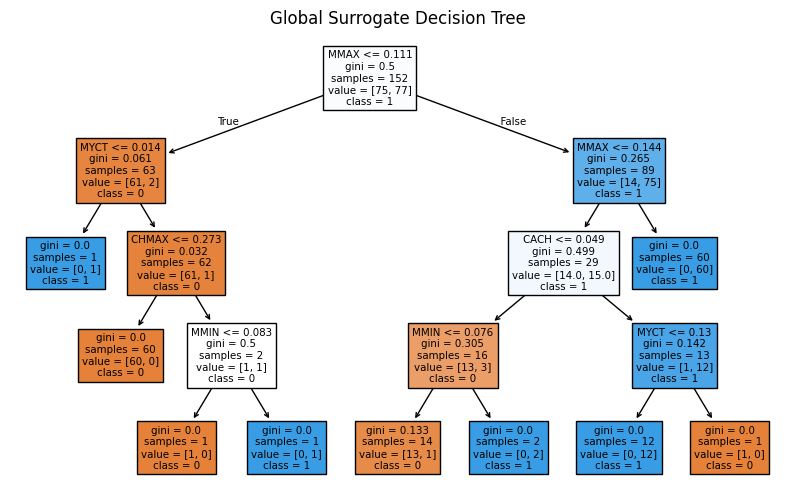

In [31]:
surrogate = DecisionTreeClassifier(max_depth=4, random_state=SEED)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
surrogate.fit(X_train, y_train_pred)
surrogate_pred = surrogate.predict(X_test)

print(f"Surrogate accuracy compared to NN: {accuracy_score(y_test_pred, surrogate_pred):.4f}")  # based on test set
print(f"Actual surrogate accuracy: {accuracy_score(y_test, surrogate_pred):.4f}")  # based on all the data

plt.figure(figsize=(10, 6))
plot_tree(surrogate, feature_names=column_names[:-1], class_names=["0", "1"], filled=True)
plt.title("Global Surrogate Decision Tree")
plt.show()

### Explanation of the decisions

To explain why decisions were made as they were made in case of NN, we used guided gradient proposed by the project description and tested it on the sample alternatives we set back in the XGBoost section. 0th alternative doesn't show any gradient (jnternet suggests that the gradient might be fully saturated for that instance), while for the rest of alternatives MMIN, MMAX, and CACH are clearly the most influencial criteria.

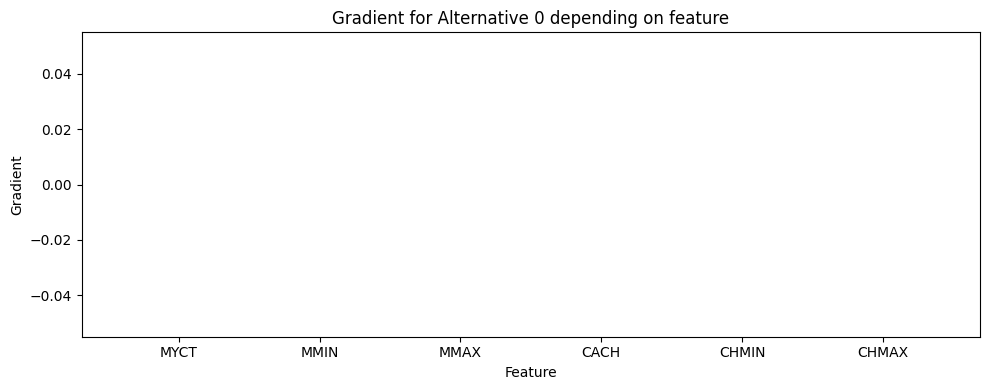

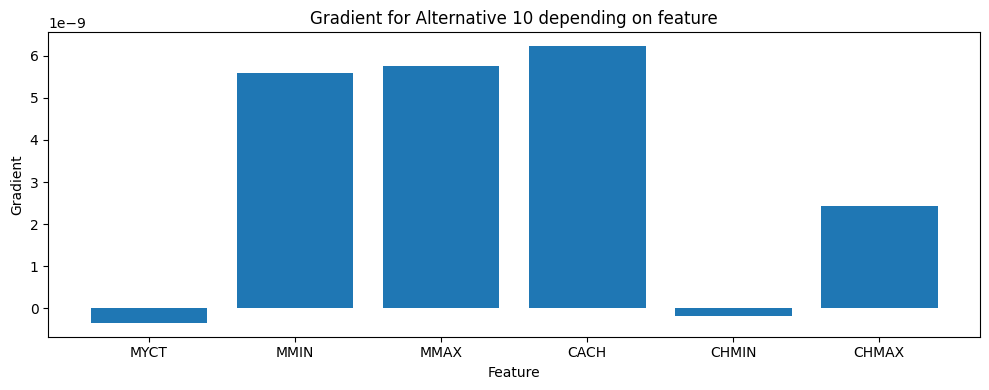

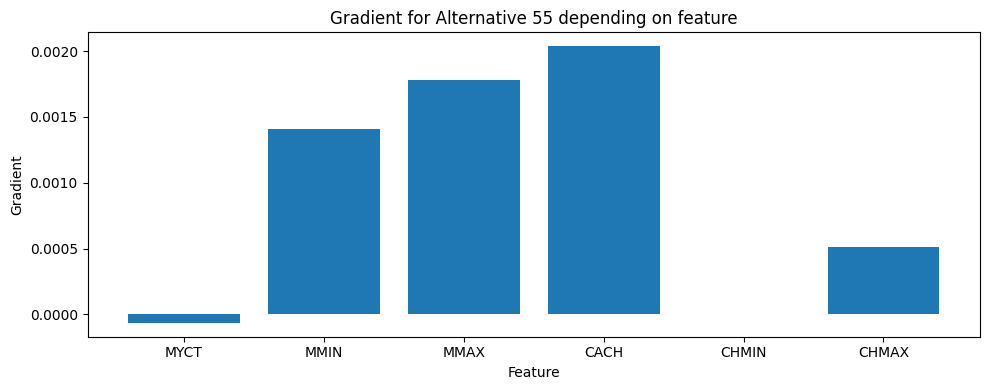

In [32]:
for i in range(3):
    x_instance = torch.FloatTensor(alt.drop('Class', axis=1).iloc[i].values)
    x_instance.requires_grad = True

    model.eval()
    output = model(x_instance)
    output.backward()

    grad = x_instance.grad

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(grad)), grad)
    plt.xticks(range(len(grad)), column_names[:-1])
    plt.title(f"Gradient for Alternative {alt_sample_idx[i]} depending on feature")
    plt.ylabel("Gradient")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()

#### Space sampling around the alternatives

Interestingly, for all 3 samples that we've used CACH was the criterion requiring the minimal change to alter the decision. It proves that it is indeed an important feature identified by the NN.

Note: In order to print SHAP values for the NN we would need to wrap our code with some library to make it compatible with shap library. We decided to skip this step because anyway the most important point here is to identify which criterion requires minimal change to alter the classification result.

In [33]:
get_minimal_change_analysis(model, column_names, alt, typeS="custom")

Alternative 1:
Minimal change: Criterion CACH (Feature 3) by -0.9700000000000006
Necessary changes on each criterion: {0: inf, 1: inf, 2: inf, 3: -0.9700000000000006, 4: inf, 5: inf}


Alternative 2:
Minimal change: Criterion CACH (Feature 3) by 0.15
Necessary changes on each criterion: {0: inf, 1: 0.19000000000000003, 2: 0.17, 3: 0.15, 4: inf, 5: inf}


Alternative 3:
Minimal change: Criterion CACH (Feature 3) by -0.05
Necessary changes on each criterion: {0: inf, 1: inf, 2: -0.060000000000000005, 3: -0.05, 4: inf, 5: inf}




### NN Summary

Our custom Neural network obtained accuracy around 95% on the CPU dataset. The model converges after 60 epochs. The Feature importance were analyzed using permutation importance. Global Surrogate was used to approximate the inner working of our NN model in the form of easy-interpretable Decision Tree. Decisions were explained using the Guided Gradient mechanism.

**Based on the model analysis**:

* MMAX and CACH are the most influencial criterion
* MMAX has a decisive influence and based on the violin plot MYCT has the least influence on the decision

**Based on the decisions**:

We showed whats the impact of each feature for particular alternatives using Guided Gradient method.